In [359]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

#### 95th percentile  treshold

In [360]:
import os
import pandas as pd

def process_commit_history(csv_file, current_time="2024-1-1"):
    df = pd.read_csv(csv_file)
    
    # Drop rows where 'date' is null to avoid NaT values
    df = df.dropna(subset=['date'])
    
    # If DataFrame is empty after dropping null dates, skip this file
    if df.empty:
        return None
    
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    df['timestamp'] = df['date'].astype('datetime64[s]')
    
    # Filter the DataFrame to include only dates up to and including the cut-off date
    df = df[df['date'] <= pd.to_datetime('2023-11-1')]

    df = df.sort_values(by=['timestamp'], ascending=True)
    
    # Focus on the most recent k commits
    
    df['interval'] = df['timestamp'].diff().dt.total_seconds()
    
    # Calculate the mean and standard deviation of commit intervals
    mean_interval = df['interval'].mean()
    sd_interval = df['interval'].std()
    
    Z = df['interval'].max()
    percentile_95 = df['interval'].dropna().quantile(0.99)
    T = pd.to_datetime(current_time)
    T_X_n = (T - df['timestamp'].iloc[-1]).total_seconds()
    time_since_last_commit_days = T_X_n / (60 * 60 * 24)
        
    classification = "unknown"
    if T_X_n  > Z:
        # Reclassify as "alive" if within a certain SD from the mean
        if abs(T_X_n - mean_interval) < sd_interval:
            classification = "alive"
        else:
            classification = "dead"
    elif T_X_n < percentile_95:
        classification = "alive"
        
    mean_interval= mean_interval / (60 * 60 * 24)
    
    repo_name = os.path.basename(csv_file).split('.')[0]
    return {
        'Repo': repo_name,
        'Z': Z,
        'T_X_n': T_X_n,
        'Percentile_95': percentile_95,
        'MeanInterval(days)': mean_interval,
        'SDInterval': sd_interval,
        'Classification': classification,
        'TimeSinceLastCommit(days)': time_since_last_commit_days
    }

folder_path = '/Users/ethan/Documents/Data science/MQP/main_repo_df/Data/CommitData'  
results_list = []  

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        csv_path = os.path.join(folder_path, file_name)
        result = process_commit_history(csv_path)
        if result:  # Only add if result is not None
            results_list.append(result)

# Use pd.concat to create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)


C:\Users\ethan\AppData\Local\Temp\ipykernel_6552\1700274219.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)


IndexError: single positional indexer is out-of-bounds

    classification = "unknown"
    if T_X_n > Z:
        classification = "dead"
        # If classified as dead but within 1 SD from the mean, reclassify as alive
        if abs(T_X_n - mean_interval) < sd_interval:
            classification = "alive"
    elif T_X_n < percentile_95:
        classification = "alive"
   

In [ ]:
results_df.head(1)

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,57748.88,0.074827,73483.954057,dead,858.4439


In [ ]:
results_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,57748.88,0.074827,7.348395e+04,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,10496672.0,2072525.42,1.654147,5.514041e+05,dead,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,28776555.90,41.994261,9.370872e+06,dead,442.272384
3,C_2d-inc_developer_quest,6848421.0,127440288.0,500962.82,0.628362,4.878035e+05,dead,1475.003333
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,52620549.82,30.238753,1.018087e+07,alive,114.686644
...,...,...,...,...,...,...,...,...
1746,C_zpao_qrcode,31729003.0,696362.0,17433431.32,15.059033,3.848066e+06,alive,8.059745
1747,C_zqzess_rule_for_quantumultX,606525.0,577893.0,605079.04,1.200002,1.784937e+05,alive,6.688576
1748,C_zs9024_quick_psd2ugui,58344447.0,57677255.0,28574030.14,27.239227,7.661345e+06,unknown,667.560822
1749,C_zxing_zxing,5990254.0,2371857.0,1889198.30,1.564348,3.715401e+05,unknown,27.452049


In [ ]:
results_df['TimeSinceLastCommit(days)'].describe()

count    1751.000000
mean      731.497174
std       932.519463
min         1.510486
25%        32.896117
50%       283.446366
75%      1181.003287
max      5020.900463
Name: TimeSinceLastCommit(days), dtype: float64

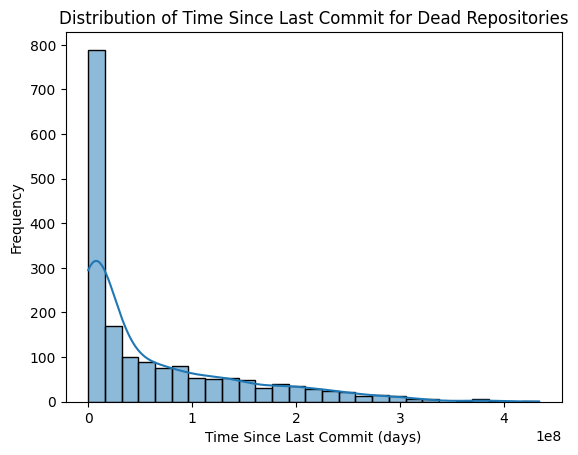

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(results_df['T_X_n'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


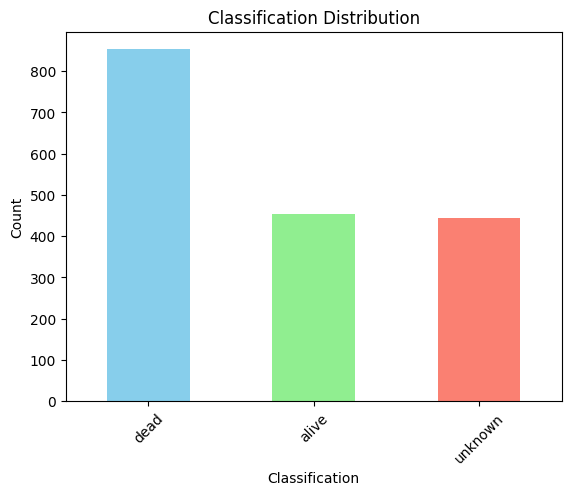

In [ ]:
import matplotlib.pyplot as plt

classification_counts = results_df['Classification'].value_counts()
classification_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Classification Distribution')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Dead repos 

In [ ]:
dead_repos_df = results_df[results_df['Classification'] == 'dead']
dead_repos_df.head(10)

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,57748.88,0.074827,7.348395e+04,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,10496672.0,2072525.42,1.654147,5.514041e+05,dead,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,28776555.90,41.994261,9.370872e+06,dead,442.272384
3,C_2d-inc_developer_quest,6848421.0,127440288.0,500962.82,0.628362,4.878035e+05,dead,1475.003333
7,C_9magnets_iOS-Developer-and-Designer-Intervie...,52066745.0,207744379.0,36757206.98,20.484703,8.236624e+06,dead,2404.448831
9,C_AbhishekChourasiya_Leetcode-Questions,356.0,128771801.0,356.00,0.004120,NaN,dead,1490.414363
10,C_abuanwar072_Quiz-App-Flutter,28052746.0,57097704.0,27029863.35,68.840289,1.124620e+07,dead,660.853056
11,C_academind_node-restful-api-tutorial,126883.0,192108057.0,125676.79,0.770515,8.529193e+04,dead,2223.472882
15,C_adamisntdead_QuSimPy,38543496.0,172234206.0,29657679.36,21.108072,6.988715e+06,dead,1993.451458
16,C_adamwulf_Columnizer-jQuery-Plugin,74968706.0,85947524.0,41150194.40,26.765644,8.544934e+06,dead,994.763009


In [ ]:

# Selecting a random row from `dead_repos_df`
random_row = dead_repos_df.sample(n=1)
random_row

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
1010,C_newbe36524_Newbe,19916846.0,107733242.0,6383383.29,6.345549,1.884510e+06,dead,1246.912523


In [ ]:
sorted_dead_repos_df = dead_repos_df.sort_values(by='TimeSinceLastCommit(days)')
sorted_dead_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
534,C_h2oai_h2ogpt,171187.0,666021.0,54414.32,0.055556,1.179415e+04,dead,7.708576
336,C_drone_drone,608314.0,1001984.0,314512.89,0.285968,6.070565e+04,dead,11.597037
1509,C_syncthing_syncthing,1119454.0,1599841.0,417864.00,0.497891,8.495365e+04,dead,18.516678
407,C_facebook_react,1107196.0,1996725.0,237676.22,0.238567,4.794619e+04,dead,23.110243
350,C_EbookFoundation_free-programming-books,1818415.0,2266985.0,512663.36,0.407012,1.070924e+05,dead,26.238252
...,...,...,...,...,...,...,...,...
1137,C_punkave_phpQuery,364.0,382092634.0,364.00,0.004213,NaN,dead,4422.368449
875,C_lorensiuswlt_NewQuickAction3D,7033736.0,385339174.0,6786744.76,18.357984,3.067312e+06,dead,4459.944144
570,C_huacnlee_quora,4059969.0,385840367.0,795069.36,0.371762,2.176633e+05,dead,4465.744988
1112,C_placemarker_jQuery-MD5,7546712.0,396091502.0,7231883.04,19.857190,2.504764e+06,dead,4584.392384


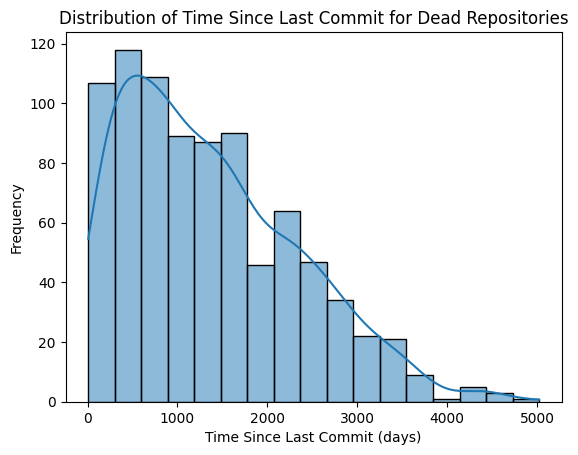

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(dead_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


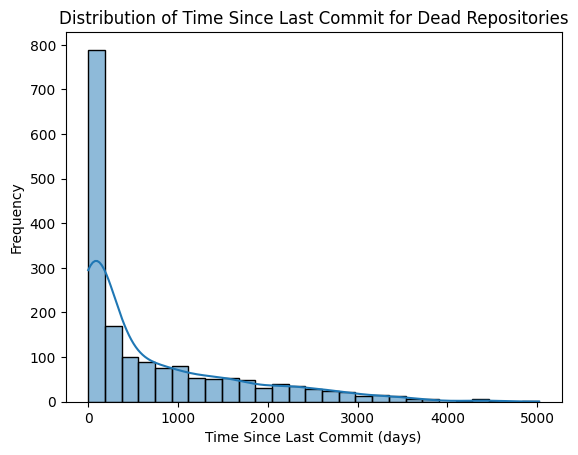

In [ ]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(results_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

#### Alive repos 

In [ ]:
alive_repos_df = results_df[results_df['Classification'] == 'alive']
alive_repos_df.head(10)


,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,5.262055e+07,30.238753,1.018087e+07,alive,114.686644
6,C_89996462_Quantumult-X,4064823.0,396044.0,5.137924e+05,0.534440,2.402217e+05,alive,4.583843
12,C_acmerobotics_road-runner-quickstart,17714735.0,609549.0,1.531000e+07,10.747102,2.527732e+06,alive,7.054965
27,C_airbnb_lottie-android,6212738.0,1404002.0,2.236991e+06,1.736325,4.372014e+05,alive,16.250023
28,C_airbnb_lottie-ios,15959705.0,890655.0,2.343683e+06,2.314557,6.745135e+05,alive,10.308507
29,C_airbus-seclab_qemu_blog,24165616.0,5057537.0,2.363523e+07,57.757322,8.605990e+06,alive,58.536308
31,C_aizvorski_video-quality,118991936.0,4859445.0,1.121753e+08,196.208139,3.324118e+07,alive,56.243576
35,C_alex-spataru_QSimpleUpdater,25583517.0,1133967.0,2.505258e+07,28.007320,5.376096e+06,alive,13.124618
42,C_alibaba_druid,2762012.0,887009.0,9.908094e+05,0.646963,1.790430e+05,alive,10.266308
45,C_alibaba_QLExpress,35595278.0,9841532.0,1.426778e+07,7.221745,2.901226e+06,alive,113.906620


In [ ]:
# Selecting a random row from `dead_repos_df`
random_row = alive_repos_df.sample(n=1)
random_row

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
1615,C_varkor_quiver,20104230.0,1047144.0,8069999.8,4.578966,1.622656e+06,alive,12.119722


In [ ]:
sorted_alive_repos_df = alive_repos_df.sort_values(by='TimeSinceLastCommit(days)', ascending=False)
sorted_alive_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
196,C_chentao0707_QrCodeScan,193643383.0,96135592.0,1.768451e+08,241.074126,6.076016e+07,alive,1112.680463
342,C_dwa012_html5-qrcode,163789712.0,89897166.0,1.010558e+08,65.078948,2.482597e+07,alive,1040.476458
1515,C_taitems_Aristo-jQuery-UI-Theme,254797562.0,82126395.0,1.502307e+08,90.497521,3.781132e+07,alive,950.536979
1590,C_udacity_AdvancedAndroid_ClassicalMusicQuiz,141406799.0,69243941.0,1.235064e+08,120.394587,3.771865e+07,alive,801.434502
1385,C_salesforce_pytorch-qrnn,133011913.0,59390753.0,1.093429e+08,84.090785,3.045419e+07,alive,687.392975
...,...,...,...,...,...,...,...,...
1176,C_qdrant_quaterion,23259267.0,212763.0,3.598153e+06,3.817342,1.690814e+06,alive,2.462535
240,C_connamara_quickfixn,60567346.0,204059.0,4.767475e+06,2.806471,1.652868e+06,alive,2.361794
1161,C_qbcore-framework_qb-phone,6978492.0,191893.0,4.926676e+06,3.109162,8.667902e+05,alive,2.220984
1215,C_qsaker_QtSwissArmyKnife,5934651.0,160170.0,9.424800e+05,0.448244,2.297457e+05,alive,1.853819


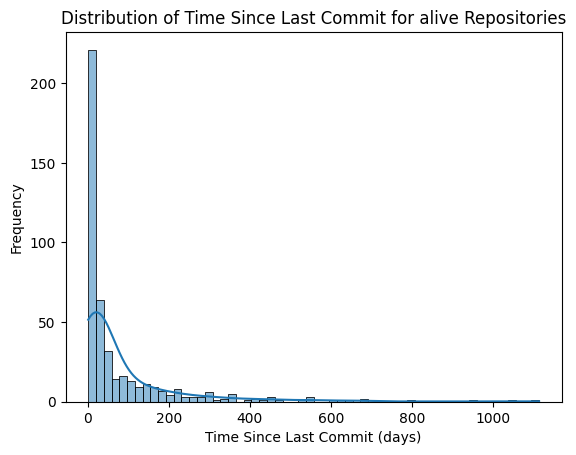

In [ ]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(alive_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for alive Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
dead_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,57748.88,0.074827,7.348395e+04,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,10496672.0,2072525.42,1.654147,5.514041e+05,dead,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,28776555.90,41.994261,9.370872e+06,dead,442.272384
3,C_2d-inc_developer_quest,6848421.0,127440288.0,500962.82,0.628362,4.878035e+05,dead,1475.003333
7,C_9magnets_iOS-Developer-and-Designer-Intervie...,52066745.0,207744379.0,36757206.98,20.484703,8.236624e+06,dead,2404.448831
...,...,...,...,...,...,...,...,...
1739,C_zhengtianzuo_QtQuickExamples,68831082.0,91388493.0,31882124.57,15.768423,8.115186e+06,dead,1057.737187
1740,C_zhihao-chen_QASystemOnMedicalGraph,5260996.0,145393563.0,4919143.32,8.984473,1.491984e+06,dead,1682.795868
1742,C_zhuxuedefeng_AiQiangGUO,8192130.0,82317576.0,7539664.08,12.130486,2.297861e+06,dead,952.749722
1743,C_ziadoz_awesome-php,9841058.0,45455853.0,3449589.05,2.447083,6.796128e+05,dead,526.109410


In [ ]:
unknown = results_df[results_df['Classification'] == 'unknown']

In [ ]:
alive_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,52620549.82,30.238753,1.018087e+07,alive,114.686644
6,C_89996462_Quantumult-X,4064823.0,396044.0,513792.35,0.534440,2.402217e+05,alive,4.583843
12,C_acmerobotics_road-runner-quickstart,17714735.0,609549.0,15309995.60,10.747102,2.527732e+06,alive,7.054965
27,C_airbnb_lottie-android,6212738.0,1404002.0,2236990.65,1.736325,4.372014e+05,alive,16.250023
28,C_airbnb_lottie-ios,15959705.0,890655.0,2343682.84,2.314557,6.745135e+05,alive,10.308507
...,...,...,...,...,...,...,...,...
1735,C_zeromicro_go-queue,14063486.0,7122496.0,12464058.14,15.123347,2.495918e+06,alive,82.436296
1737,C_zestyping_q,52270700.0,1126198.0,40271924.21,32.725967,8.678271e+06,alive,13.034699
1741,C_zhiyiYo_PyQt-Fluent-Widgets,13622388.0,671945.0,3317241.80,1.734282,8.015247e+05,alive,7.777141
1746,C_zpao_qrcode,31729003.0,696362.0,17433431.32,15.059033,3.848066e+06,alive,8.059745


In [ ]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Repo                       1751 non-null   object 
 1   Z                          1751 non-null   float64
 2   T_X_n                      1751 non-null   float64
 3   Percentile_95              1751 non-null   float64
 4   MeanInterval(days)         1751 non-null   float64
 5   SDInterval                 1732 non-null   float64
 6   Classification             1751 non-null   object 
 7   TimeSinceLastCommit(days)  1751 non-null   float64
dtypes: float64(6), object(2)
memory usage: 109.6+ KB


#### Unknown

In [ ]:
unknown = results_df[results_df['Classification'] == 'unknown']

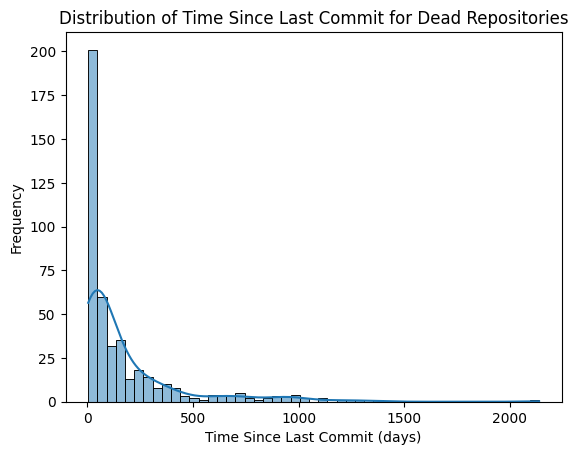

In [ ]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(unknown['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

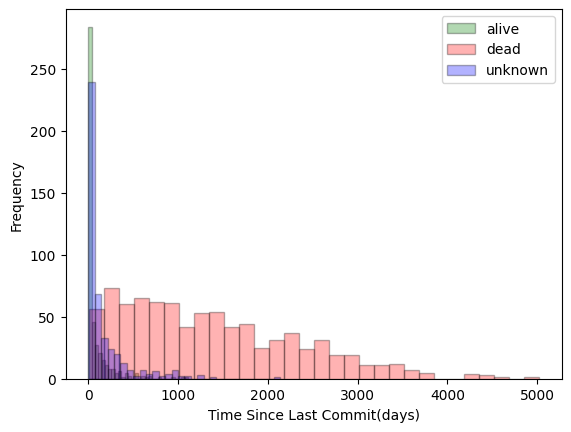

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df

# Plotting
fig, ax = plt.subplots()
colors = {'alive': 'green', 'dead': 'red', 'unknown': 'blue'}  # Example classifications
for classification, color in colors.items():
    data = results_df[results_df['Classification'] == classification]['TimeSinceLastCommit(days)']
    ax.hist(data, bins=30, alpha=0.3, label=classification, color=color, edgecolor='black')

ax.set_xlabel('Time Since Last Commit(days)')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


In [ ]:
results_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,57748.88,0.074827,7.348395e+04,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,10496672.0,2072525.42,1.654147,5.514041e+05,dead,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,28776555.90,41.994261,9.370872e+06,dead,442.272384
3,C_2d-inc_developer_quest,6848421.0,127440288.0,500962.82,0.628362,4.878035e+05,dead,1475.003333
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,52620549.82,30.238753,1.018087e+07,alive,114.686644
...,...,...,...,...,...,...,...,...
1746,C_zpao_qrcode,31729003.0,696362.0,17433431.32,15.059033,3.848066e+06,alive,8.059745
1747,C_zqzess_rule_for_quantumultX,606525.0,577893.0,605079.04,1.200002,1.784937e+05,alive,6.688576
1748,C_zs9024_quick_psd2ugui,58344447.0,57677255.0,28574030.14,27.239227,7.661345e+06,unknown,667.560822
1749,C_zxing_zxing,5990254.0,2371857.0,1889198.30,1.564348,3.715401e+05,unknown,27.452049


In [ ]:
results_df.columns

Index(['Repo', 'Z', 'T_X_n', 'Percentile_95', 'MeanInterval(days)',
       'SDInterval', 'Classification', 'TimeSinceLastCommit(days)'],
      dtype='object')

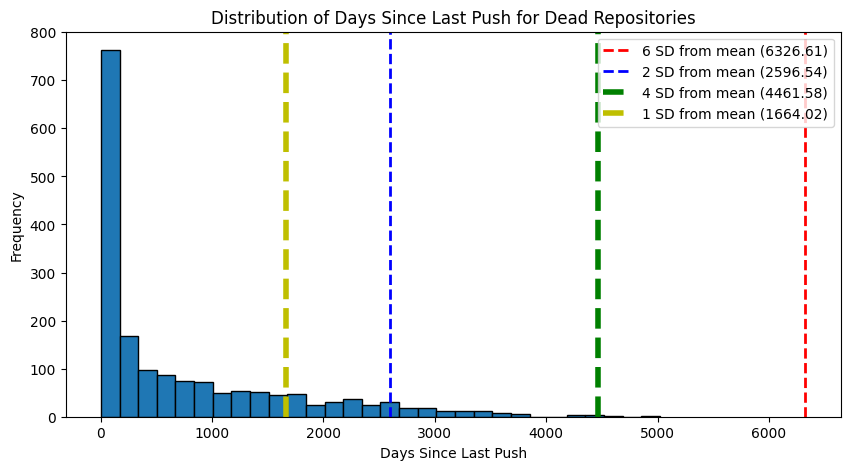

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# We'll use the filtered_repo which contains 'daysSinceLastPush' between 0 and 300
# First calculate the mean and standard deviation
mean_value = results_df['TimeSinceLastCommit(days)'].mean()
std_dev = results_df['TimeSinceLastCommit(days)'].std()

# Calculate the position of the line at 6 standard deviations from the mean
line_position = mean_value + 6*std_dev

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(results_df['TimeSinceLastCommit(days)'], bins=30,  edgecolor='black')
plt.title('Distribution of Days Since Last Push for Dead Repositories')
plt.xlabel('Days Since Last Push')
plt.ylabel('Frequency')

# Calculate the position of the line at 6 standard deviations from the mean
line_position = mean_value + 6*std_dev
plt.axvline(line_position, color='r', linestyle='dashed', linewidth=2, label=f'6 SD from mean ({line_position:.2f})')

# Calculate the position of the line at 2 standard deviations from the mean
line_position = mean_value + 2*std_dev
plt.axvline(line_position, color='b', linestyle='dashed', linewidth=2, label=f'2 SD from mean ({line_position:.2f})')

# Calculate the position of the line at 4 standard deviations from the mean
line_position = mean_value + 4*std_dev
plt.axvline(line_position, color='g', linestyle='dashed', linewidth=4, label=f'4 SD from mean ({line_position:.2f})')

# Calculate the position of the line at 1 standard deviations from the mean
line_position = mean_value + 1*std_dev
plt.axvline(line_position, color='y', linestyle='dashed', linewidth=4, label=f'1 SD from mean ({line_position:.2f})')

# Add a legend to the plot
plt.legend()

#plt.xlim(0, 300)  # This ensures that the x-axis only shows the range from 0 to 300
plt.show()



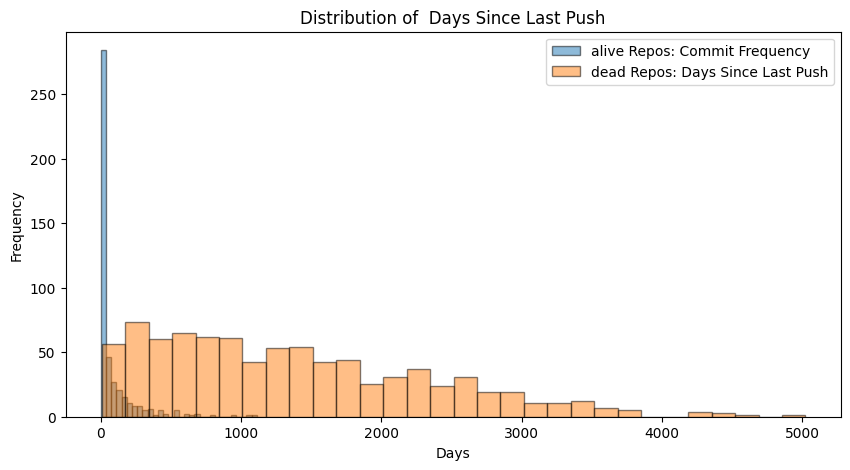

In [ ]:
# Assuming 'dead_repos' and 'alive_repos' are DataFrames that contain the 'commitFrequency' and 'daysSinceLastPush' columns respectively
# We will plot the histograms for both features in one plot for comparison

plt.figure(figsize=(10, 5))

# Plotting 'commitFrequency' for dead repositories
plt.hist(alive_repos_df['TimeSinceLastCommit(days)'], bins=30, alpha=0.5, label='alive Repos: Commit Frequency', edgecolor='black')

# Plotting 'daysSinceLastPush' for alive repositories
plt.hist(dead_repos_df['TimeSinceLastCommit(days)'], bins=30, alpha=0.5, label='dead Repos: Days Since Last Push', edgecolor='black')

# Adding title, labels, and legend
plt.title('Distribution of  Days Since Last Push')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.legend()
plt.show()



#### merge datasets

In [ ]:
graph_data=pd.read_csv('../data/ml_data/graph_data_stats.csv', sep=",",index_col=0)
graph_data.drop('index', axis=1, inplace=True)
graph_data.head(1)

,owner,repo,stars,dateCreated,datePushed,numCommits,openIssues,closedIssues,totalIssues,totalAdditions,...,Fun Rt,nloc Rt,Halstead Volume,Maintainability Index,open_close_ratio,daysSinceLastPush,repoAgeDays,commitFrequency,closedIssueRatio,openIssueRatio
0,facebook,react,216019,2013-05-24 16:15:54,2023-12-08 00:51:20,16117,1557,25219,26776,2734078.0,...,0.01,0.06,1831.576017,57.03145,0.061737,0,3849,0.238816,0.941816,0.058147
